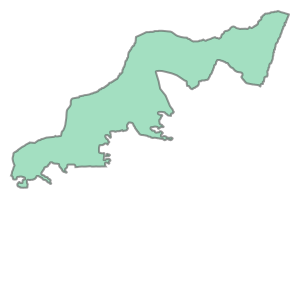

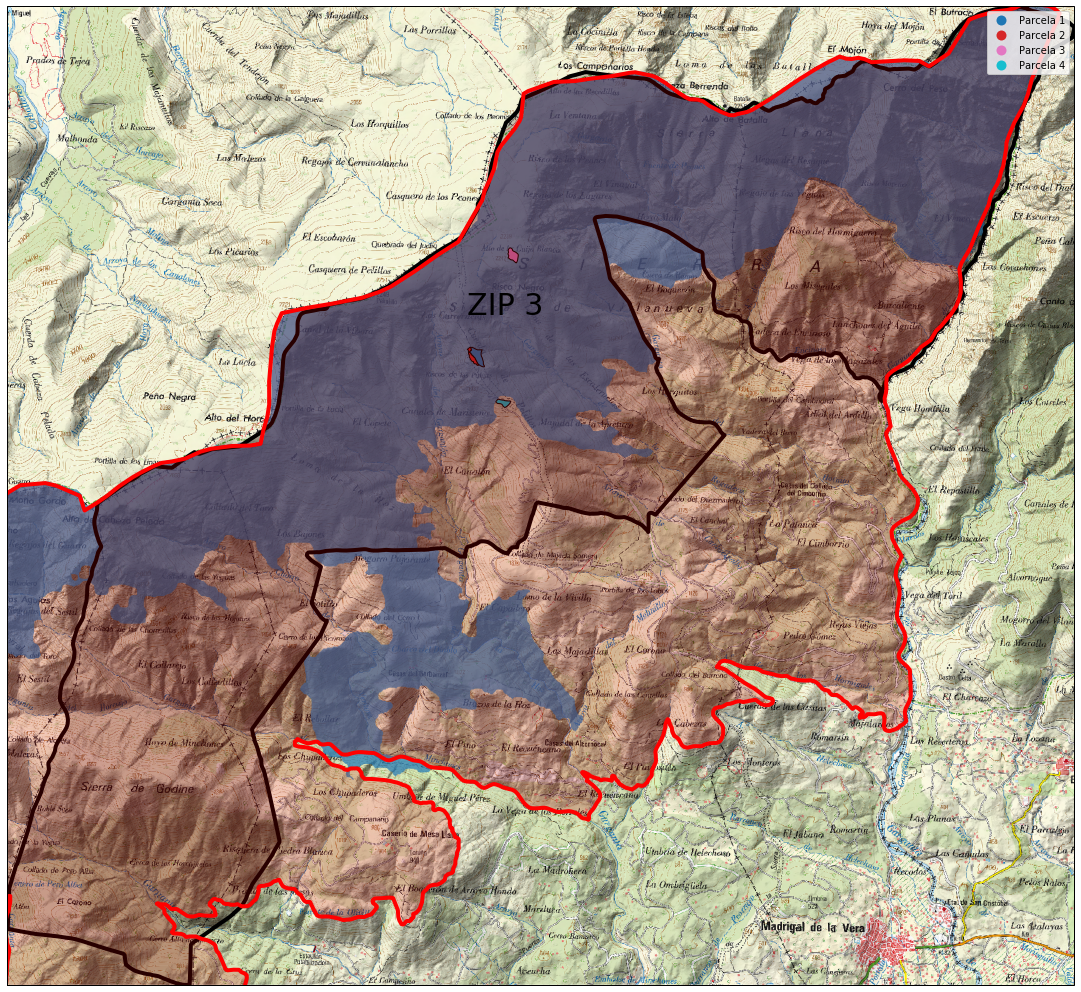

In [1]:
import psycopg2
from config import config
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

params = config()
conn = psycopg2.connect(**params)

proj = ccrs.epsg('25830')
zona = 'madrigal'
comarca = 'vera'
ze = gpd.read_postgis('''
        SELECT * 
        FROM zona_estudio_{}'''.format(zona), conn)

zec = gpd.read_postgis('select * from sierra_gredos_y_valle_jerte', conn)

zonificacion = gpd.read_file('../BRUTOS/ZEC/zonificacion_{}/zonificacion_{}.shp'.format(comarca, comarca), encoding='utf-8')
parcelas = gpd.read_postgis('''
        SELECT nombre, ST_Transform(geom, 25830) as geom
        FROM quema_{}_todas'''.format(zona), conn)

display(zonificacion.geometry[1].intersection(ze.geom[0]))
zonificacion['text_coord'] = zonificacion['geometry'].apply(lambda x: x.intersection(ze.geom[0]).representative_point().coords[:])
zonificacion = zonificacion.loc[zonificacion['text_coord'].str.len() > 0]

zonificacion['text_coord'] = [c[0] for c in zonificacion['text_coord'] if c]
         
fig = plt.figure(figsize=(24,18))
ax = plt.axes(projection=proj)
lim = list(ze.bounds.iloc[0])
ax.set_extent([lim[0],lim[2], lim[1], lim[3]], crs=proj)

ax.add_wms(wms='https://www.ign.es/wms-inspire/mapa-raster', layers=['mtn_rasterizado'])
ax.add_geometries(ze['geom'], facecolor=(0.1,0,0,0.2), edgecolor='black', linewidth=4, crs=proj)
ax.add_geometries(zec['geom'], facecolor=(0.8,0,0,0.2), edgecolor='red', linewidth=4, crs=proj)
zonificacion.plot(ax=ax, column='nombre', alpha=0.7)
for idx, row in zonificacion.iterrows():
    plt.annotate(s=row['codigo'], xy=row['text_coord'], size=30)
parcelas.plot(ax=ax, column='nombre', legend=True, edgecolor='black')
fig.savefig('static/images/afeccion_zonificacion_{}'.format(zona), bbox_inches='tight', pad_inches=0)
plt.show()
plt.close(fig)

conn.close()

array(['Cervunal carpetano-leonés occidental y laciano-ancarense',
       'Piornales serranos orosubmediterráneos bejarano-gredenses centrales y orientales',
       'Vegetación glerícola de pedregales móviles silíceos quionófilos oro-crioromediterráneos gredenses'],
      dtype=object)

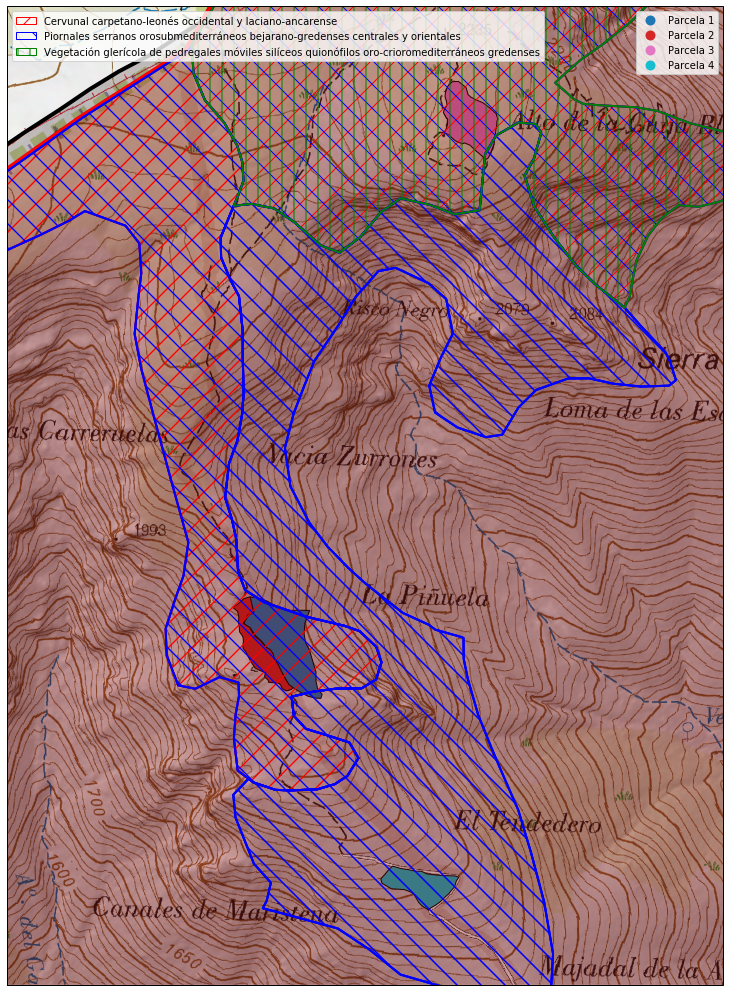

In [4]:
import matplotlib.patches as mpatches

conn = psycopg2.connect(**params)

buffer = 200
lim = [parcelas.bounds.min()['minx'] - 3*buffer, 
       parcelas.bounds.max()['maxx'] + 3*buffer, 
       parcelas.bounds.min()['miny'] - buffer, 
       parcelas.bounds.max()['maxy'] + buffer]

habitats = gpd.read_postgis('''
            select codue, a.nom_habita, nom_comun, generico, alianza, spsalianza, st_transform(a.geom, 25830) as geom 
            from atlashabitats2005_extremadura a, quema_{}_todas b
            where st_intersects(a.geom, st_transform(b.geom, 23030))'''.format(zona), conn)

fig = plt.figure(figsize=(24,18))
ax = plt.axes(projection=proj)
ax.set_extent(lim, crs=proj)
h = habitats['nom_comun'].unique()
display(h)
hatchs = ['/', '\\', '|', '-', 'o']
colors = ['red', 'blue', 'green', 'brown', 'yellow']

ax.add_wms(wms='https://www.ign.es/wms-inspire/mapa-raster', layers=['mtn_rasterizado'])
ax.add_geometries(ze['geom'], facecolor=(0.1,0,0,0.2), edgecolor='black', linewidth=4, crs=proj)
ax.add_geometries(zec['geom'], facecolor=(0.8,0,0,0.2), edgecolor='red', linewidth=4, crs=proj)

legend_element = []
for hab, color, hatch in zip(h, colors, hatchs):
    ax.add_geometries(habitats.loc[habitats['nom_comun'] == hab]['geom'], 
                      facecolor='none', hatch=hatch, edgecolor=color, linewidth=2, crs=proj)
    legend_element.append(mpatches.Patch(facecolor='none', edgecolor=color, hatch=hatch, label=hab))
l = ax.legend(handles = legend_element, loc='upper left')
parcelas.plot(ax=ax, column='nombre', legend=True, edgecolor='black')
plt.gca().add_artist(l)

fig.savefig('static/images/afeccion_habitats_{}'.format(zona), bbox_inches='tight', pad_inches=0)
plt.show()
plt.close(fig)

conn.close()